In [1]:
import glob
import rasterio as rio
from rasterio import mask, features
import numpy as np
import shapely.wkt as wkt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sub_area = wkt.loads("MULTIPOLYGON (((77462.8497438607 73703.6291953883,75345.6534984474 73935.3621177719,75366.720127755 74009.0953203485,74843.5654999498 74153.050620617,74836.5432901806 74184.6505645784,74889.2098634495 74542.7832628075,74854.0988146036 74985.182478267,74861.1210243728 75301.1819178809,74882.1876536804 75536.4259451491,74959.4319611415 75813.8032310324,76511.3403201343 75448.6483230341,76967.7839551322 75329.2707569577,76985.3394795552 74995.7157929208,77564.671785514 74005.5842154639,77462.8497438607 73703.6291953883)))")


car_dataset = rio.open('car_raster.tif', 'r', crs='EPSG:2169')
cars, transf_car =  rio.mask.mask(car_dataset, [sub_area], crop=True, indexes=1)

pedestian_dataset = rio.open('/mnt/ric_dais_nfs_maccari/gabriel/data/dtm_fusion/luxemburg_roads_mask.tif', 'r', crs='EPSG:2169')
pedestrians, transf_ped =  rio.mask.mask(pedestian_dataset, [sub_area], crop=True, indexes=1)

result_files = glob.glob('/mnt/ric_dais_nfs_maccari/gabriel/results/WONS23/*/luxemburg/threestep/0/r1/1/*/*/viewshed.tif')


In [11]:
results = []
for f in result_files:
    run_t, city, strategy, subarea, ranking, k, ratio, dens = f.split('/')[6:-1]
    with rio.open(f, 'r', crs='EPSG:2169') as dataset:
        res, transf =  rio.mask.mask(dataset, [sub_area], crop=True, indexes=1)
    if run_t == 'results_False':
        algorithm = 'pedestrian'
    elif run_t == 'results_True':
        algorithm = 'cars'
    else:
        algorithm = ''
        break
    ##When we compare something not pedestrian with pedestian we need to crop out the shape of the cars
    if algorithm == 'pedestrian':
        local_pedestrians = pedestrians
    else:
        local_pedestrians = np.multiply(pedestrians.astype(bool), cars)#np.ones_like(pedestrians)*np.nan#
        #print(algorithm, local_pedestrians.sum(), cars.sum(), cars.astype(bool).sum())
    cars_res = np.where(res>0, cars, 0)
    ##cars version
    results.append({'metric': 'cars',
                    'algorithm': algorithm, 
                    'dens': int(dens), 
                    'ratio': float(ratio),
                    'sum': cars_res.sum(),
                    'total': cars.sum(),
                    'coverage': cars_res.sum()/cars.sum(),
                    })
    # boolcar_res = np.where(res>0, 1, 0)
    # #boolcar version
    # results.append({'metric': 'boolcar',
    #                 'algorithm': algorithm,
    #                 'dens': int(dens), 
    #                 'ratio': float(ratio),
    #                 'sum': boolcar_res.sum(),
    #                 'total': np.count_nonzero(cars),
    #                 'coverage': boolcar_res.sum()/np.count_nonzero(cars)
    #                 })
    # #pedestrian version
    pedestrian_res = np.where(res>0,1,0)
    results.append({'metric': 'pedestrian',
                    'algorithm': algorithm,
                    'dens': int(dens), 
                    'ratio': float(ratio),
                    'sum': np.count_nonzero(pedestrian_res),
                    'total': np.count_nonzero(local_pedestrians),
                    'coverage': np.count_nonzero(pedestrian_res)/np.count_nonzero(local_pedestrians)
                    })
    
res_df = pd.DataFrame(results)

algorithm pedestrian                 cars           
metric          cars pedestrian      cars pedestrian
dens                                                
5           0.593395   0.400478  0.690536   2.287747
10          0.808845   0.607658  0.868709   3.429897
15          0.891398   0.732118  0.937078   4.220537
20          0.940432   0.815789  0.965950   4.735157
25          0.955256   0.870855  0.981610   5.123707
30          0.976180   0.907071  0.991656   5.453467
35          0.984825   0.938620  0.995950   5.716956
40          0.989256   0.957939  0.998330   5.960425
45          0.991272   0.968461  0.999094   6.062117
50          0.992904   0.977141  0.999441   6.157072
55          0.994102   0.982528  0.999537   6.239474
60          0.996317   0.987336  0.999537   6.241926
65          0.996696   0.990148  0.999537   6.243184
70          0.997573   0.991793  0.999541   6.249783
75          0.997984   0.993227  0.999542   6.251186
80          0.998740   0.994129  0.999542   6.

(0.4, 1.0)

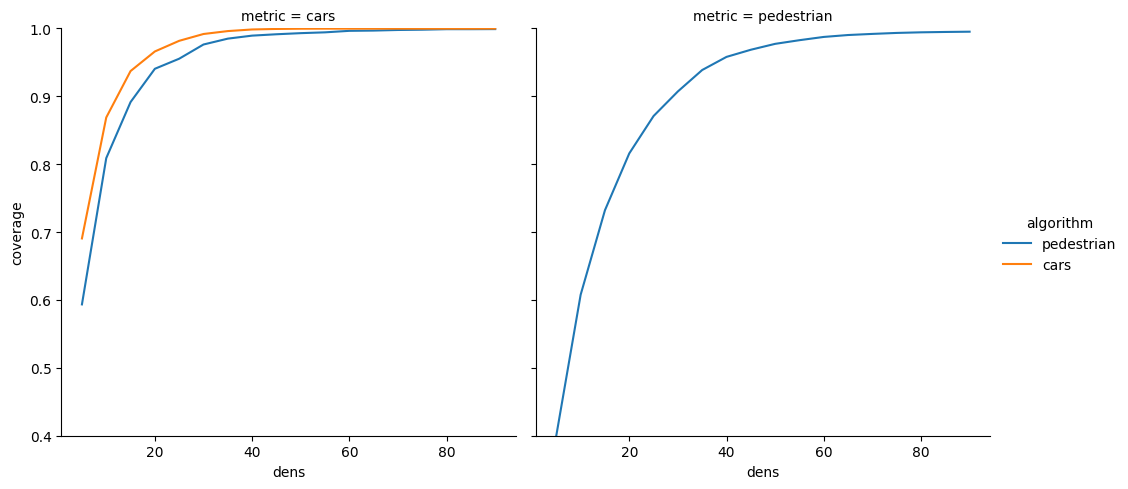

In [12]:
filt_data = res_df[(res_df.dens < 91) & (res_df.ratio ==4.0)]
print(filt_data.pivot('dens', ['algorithm', 'metric'], 'coverage'))
sns.relplot(data=filt_data, x='dens', y='coverage', kind='line', hue='algorithm', col='metric')
#print(filt_data[filt_data.metric=='pedestrian'])
plt.ylim([0.4,1])

In [54]:
fr = open('/mnt/ric_dais_nfs_maccari/gabriel/results/WONS23/results_cars_bool/luxemburg/threestep/0/r1/1/ranking_5.txt') 
print(len(fr.read().split(',')))
fr = open('/mnt/ric_dais_nfs_maccari/gabriel/results/WONS23/results_cars/luxemburg/threestep/0/r1/1/ranking_5.txt') 
print(len(fr.read().split(',')))

217
1254
